In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

# Check device and print info
device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
def base_loss(input, target):
    return F.l1_loss(input, target)

def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [3]:
class FeatureLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(weights='DEFAULT').features.eval()
        # Use fewer layers for memory efficiency
        self.blocks = nn.ModuleList([
            vgg[:4],   # First block
            vgg[4:9],  # Second block
        ])
        
        for bl in self.blocks:
            for p in bl.parameters():
                p.requires_grad = False
    
    def forward(self, input, target):
        loss = base_loss(input, target)
        
        x_in, x_target = input, target
        for block in self.blocks:
            x_in = block(x_in)
            x_target = block(x_target)
            loss += base_loss(x_in, x_target)
            # Add gram matrix loss with smaller weight
            loss += base_loss(gram_matrix(x_in), gram_matrix(x_target)) * 0.1
        
        return loss

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simplified encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        # Simplified decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
class ImageEnhancementDataset(Dataset):
    def __init__(self, image_dir, size=128):
        self.image_dir = Path(image_dir)
        self.image_files = list(self.image_dir.glob('*.jpg')) + list(self.image_dir.glob('*.png'))
        self.transform = transforms.Compose([
            transforms.Resize(size),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        return image, image

In [6]:
def train_model(image_dir, num_epochs=5, batch_size=4, size=128):
    dataset = ImageEnhancementDataset(image_dir, size=size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    generator = Generator().to(device)
    feature_loss = FeatureLoss().to(device)
    optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
    
    print("Starting training...")
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            enhanced = generator(inputs)
            loss = feature_loss(enhanced, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
        
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch} completed. Average Loss: {avg_loss:.4f}')
    
    return generator

In [7]:
# Set your image directory path
image_path = 'FGADR/0'

In [8]:
# Train with small images and batch size
model = train_model(image_path, num_epochs=2, batch_size=32, size=128)

Starting training...
Epoch: 0, Batch: 0, Loss: 2.4547
Epoch: 0, Batch: 10, Loss: 2.1985
Epoch: 0, Batch: 20, Loss: 1.9956
Epoch: 0, Batch: 30, Loss: 1.7129
Epoch: 0, Batch: 40, Loss: 1.5724
Epoch: 0, Batch: 50, Loss: 1.4165
Epoch 0 completed. Average Loss: 1.8494
Epoch: 1, Batch: 0, Loss: 1.4728
Epoch: 1, Batch: 10, Loss: 1.4227
Epoch: 1, Batch: 20, Loss: 1.3905
Epoch: 1, Batch: 30, Loss: 1.4078
Epoch: 1, Batch: 40, Loss: 1.3340
Epoch: 1, Batch: 50, Loss: 1.3866
Epoch 1 completed. Average Loss: 1.3881


In [9]:
# Save the model
torch.save(model.state_dict(), 'enhancement_model.pth')

In [16]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

def enhance_image(model_path, image_path, output_path='enhanced_output.jpg'):
    # Initialize the model architecture
    model = Generator().to(device)
    
    # Load the saved state dictionary
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Prepare the image
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Load and transform image
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Generate enhanced image
    with torch.no_grad():
        enhanced = model(img_tensor)
    
    # Convert back to image
    enhanced = enhanced.squeeze(0).cpu()
    enhanced = enhanced * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
              torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    enhanced = enhanced.clamp(0, 1)
    enhanced = transforms.ToPILImage()(enhanced)
    
    # Save the enhanced image
    enhanced.save(output_path)
    return enhanced

In [17]:
# Path to your saved model (after training)
model_path = 'enhancement_model.pth'  # or whatever name you saved your model as

In [18]:
model_path

'enhancement_model.pth'

In [19]:
# Path to test image
test_image_path = 'FGADR/1/f481f76a6b75.png'

In [20]:
test_image_path

'FGADR/1/f481f76a6b75.png'

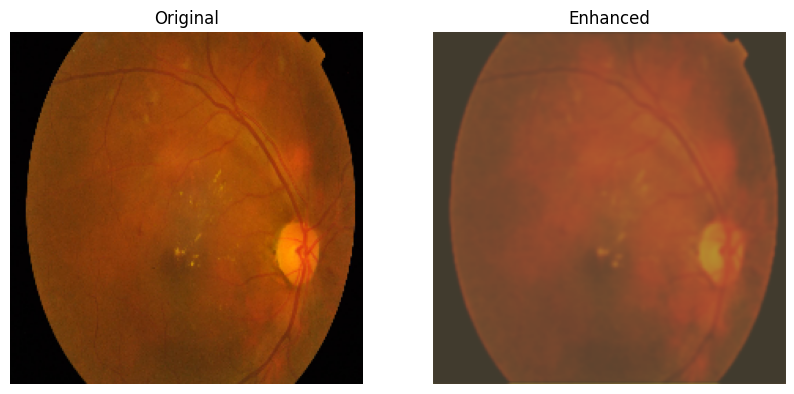

In [21]:
# Enhance the image
enhanced_image = enhance_image(
    model_path=model_path,
    image_path=test_image_path,
    output_path='enhanced_result.jpg'
)

# Display original and enhanced images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(Image.open(test_image_path))
ax1.set_title('Original')
ax1.axis('off')

ax2.imshow(enhanced_image)
ax2.set_title('Enhanced')
ax2.axis('off')

plt.show()

In [30]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device found")


False
0
No CUDA device found


Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\ompat\Downloads\DRD_GAN\venv\Scripts\python.exe -m pip install --upgrade pip' command.
